# Simple usage examples

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline as ScipyBSpline

from splinex import BSpline
from splinex.utils import clamp_ctrls, compute_knots

## Classic usage

Run spline on a matrix w. two dimensions: n. controls and n. dimensions of data.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


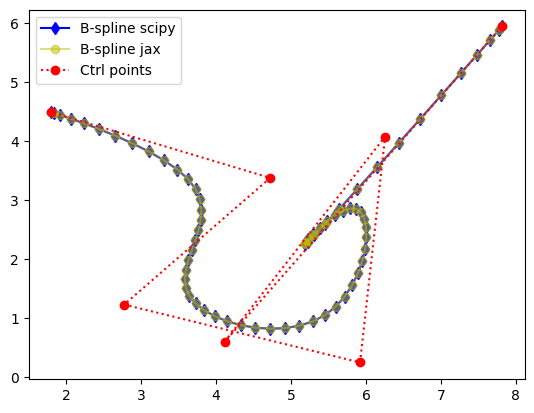

In [2]:
# Dummy points for interpolation
tau = .1
degree = 3
points = jax.random.uniform(jax.random.PRNGKey(123), (7, 2), minval=0, maxval=8)
n_pts = points.shape[0]
sim_steps = int(n_pts // tau)

# scipy -- only included for comparison
sim_steps = int(points.shape[-2] // tau)
knots = compute_knots(n_pts, degree)
ctrls = clamp_ctrls(points)
times = jnp.linspace(0., 1., sim_steps, True)
bspl = ScipyBSpline(knots, ctrls, degree)
scipy_curve = bspl(times)

# splinex
splinex_bspl = BSpline(n_pts, sim_steps)
splinex_curve, _, _ = splinex_bspl(points)

# Plotting
plt.plot(*scipy_curve.T, "bd-", label="B-spline scipy")
plt.plot(*splinex_curve.T, "yo-", label="B-spline jax", alpha=.5)
plt.plot(*points.T, "ro:", label="Ctrl points")
plt.legend();

## Batched usage

You can use `splinex` for batched interpolations, i.e., directly compute the splines for multiple inputs in parallel.

This can be useful for applications such as in roborics where you may wish to interpolate multiple trajectories in parallel.

5


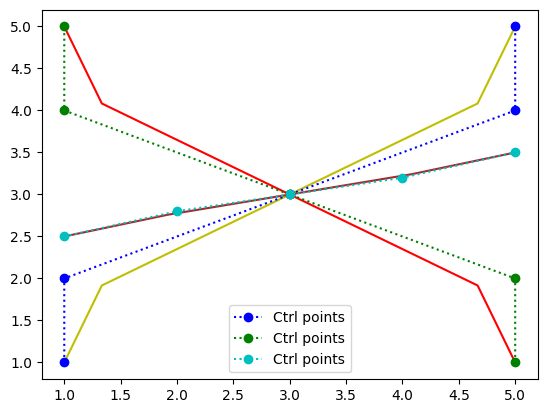

In [9]:
# Dummy points for illustrationSimple
tau = 1.
degree = 3
points = jnp.array([[[1, 1, 3, 5, 5], [1, 2, 3, 4, 5]], 
                   [[5, 5, 3, 1, 1], [1, 2, 3, 4, 5]], 
                   [[1, 2, 3, 4, 5], [2.5, 2.8, 3, 3.2, 3.5]],])
points = points.transpose(0, 2, 1)
n_pts = points.shape[1]
sim_steps = int(n_pts // tau)

# scipyn_pts
times = jnp.linspace(0., 1., sim_steps, True)
knots = compute_knots(n_pts)
padded_pts = clamp_ctrls(points)
bspl = ScipyBSpline(knots, padded_pts, degree)
ctrl_splines = jnp.array([bspl(t) for t in times])
ctrl_splines = ctrl_splines.reshape(
    sim_steps, points.shape[0], points.shape[-1]
).transpose(1, 0, 2)

# splinex
splinex_bspl = BSpline(n_pts, sim_steps)
splinex_curve, _, _ = splinex_bspl(points)

colors = ["b", "g", "c"]
colors2 = ["y", "r", "brown"]
for i in range(points.shape[0]):
    plt.plot(*splinex_curve[i].T, f"{colors2[i]}")
    plt.plot(*points[i].T, f"{colors[i]}o:", label="Ctrl points")
plt.legend();